<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime

2024-06-02 17:15:15.874235: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 17:15:15.902545: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 17:15:16.102190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 17:15:16.102246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 17:15:16.144016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Utilities

In [2]:
# def plot_series(x, y, format="-", start=0, end=None,
#                 title=None, xlabel=None, ylabel=None, legend=None ):
#     """
#     Visualizes time series data

#     Args:
#       x (array of int) - contains values for the x-axis
#       y (array of int or tuple of arrays) - contains the values for the y-axis
#       format (string) - line style when plotting the graph
#       start (int) - first time step to plot
#       end (int) - last time step to plot
#       title (string) - title of the plot
#       xlabel (string) - label for the x-axis
#       ylabel (string) - label for the y-axis
#       legend (list of strings) - legend for the plot
#     """

#     # Setup dimensions of the graph figure
#     plt.figure(figsize=(10, 6))

#     # Check if there are more than two series to plot
#     if type(y) is tuple:

#       # Loop over the y elements
#       for y_curr in y:

#         # Plot the x and current y values
#         plt.plot(x[start:end], y_curr[start:end], format)

#     else:
#       # Plot the x and y values
#       plt.plot(x[start:end], y[start:end], format)

#     # Label the x-axis
#     plt.xlabel(xlabel)

#     # Label the y-axis
#     plt.ylabel(ylabel)

#     # Set the legend
#     if legend:
#       plt.legend(legend)

#     # Set the title
#     plt.title(title)

#     # Overlay a grid on the graph
#     plt.grid(True)

#     # Draw the graph on screen
#     plt.show()

In [33]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:
        # Plot each y series
        for i, y_curr in enumerate(y):
            plt.plot(x[start:end], y_curr[start:end], format[i])
    else:
        # Plot the single y series
        plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
        plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Get the Dataset

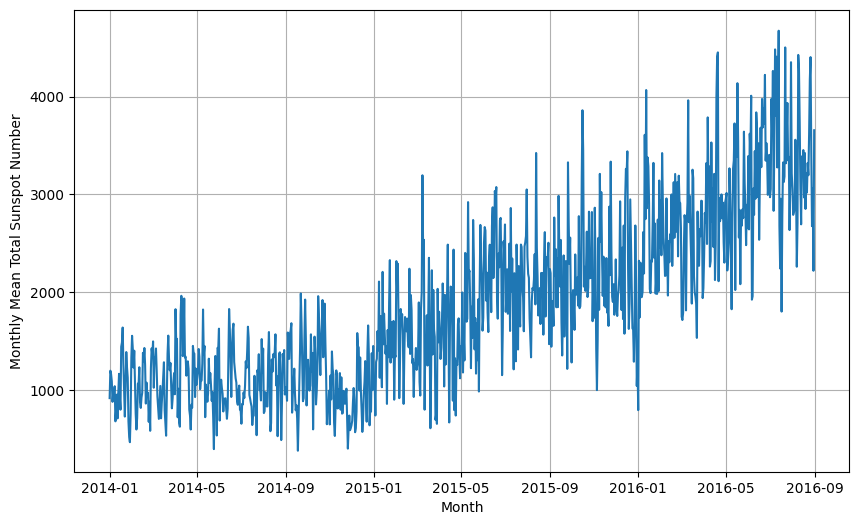

In [32]:
# Initialize lists
dates = []
sunspots = []

# Open CSV file
with open('../Dataset/sales_data_processed.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
      # Parse date and append
      dates.append(datetime.strptime(row[0], '%Y-%m-%d'))
      sunspots.append(float(row[1]))

# Convert lists to numpy arrays
time = np.array(dates)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [4]:
# Define the split time
ROW_COUNT = len(series)

print(f"Number of rows (excluding header): {ROW_COUNT}")


Number of rows (excluding header): 974


## Split the Dataset

In [5]:
# Define the split time
SPLIT_TIME = int(0.8 * ROW_COUNT)

# Get the train set
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]

# Get the validation set
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

In [6]:
print(f"x_train shape: {x_train.shape}")
print(f"x_valid shape: {x_valid.shape}")

x_train shape: (779,)
x_valid shape: (195,)


## Prepare Features and Labels

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.repeat(10)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

As mentioned in the lectures, if your results don't look good, you can try tweaking the parameters here and see if the model will learn better.

In [8]:
# Parameters
WINDOW_SIZE = 7
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

# Generate the dataset windows
train_set = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

## Build the Model

You've seen these layers before and here is how it looks like when combined.

In [13]:
from tensorflow.keras.layers import Conv1D, Dense, LSTM
from tensorflow.keras.regularizers import l2

# Build the Model
model = tf.keras.models.Sequential([
    Conv1D(
        filters=16, 
        kernel_size=3, 
        activation="relu", 
        padding='causal', 
        input_shape=[WINDOW_SIZE, 1], 
        kernel_regularizer=l2(0.001)
        ),
    LSTM(64, return_sequences=True, activation='relu'),
    LSTM(32, return_sequences=False, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 16)             64        
                                                                 
 lstm (LSTM)                 (None, 7, 64)             20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33889 (132.38 KB)
Trainable params: 33889 

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [15]:
# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [16]:
history = model.fit(train_set, epochs=1000)

Epoch 1/1000


242/242 [==============================] - 3s 4ms/step - loss: 499.3152 - mae: 499.8135
Epoch 2/1000
242/242 [==============================] - 1s 4ms/step - loss: 379.8261 - mae: 380.3247
Epoch 3/1000
242/242 [==============================] - 1s 4ms/step - loss: 380.1333 - mae: 380.6319
Epoch 4/1000
242/242 [==============================] - 1s 4ms/step - loss: 391.6906 - mae: 392.1889
Epoch 5/1000
242/242 [==============================] - 1s 4ms/step - loss: 382.5248 - mae: 383.0232
Epoch 6/1000
242/242 [==============================] - 1s 4ms/step - loss: 385.2171 - mae: 385.7156
Epoch 7/1000
242/242 [==============================] - 1s 4ms/step - loss: 361.1992 - mae: 361.6975
Epoch 8/1000
242/242 [==============================] - 1s 4ms/step - loss: 345.8563 - mae: 346.3547
Epoch 9/1000
242/242 [==============================] - 1s 4ms/step - loss: 335.6789 - mae: 336.1773
Epoch 10/1000
242/242 [==============================] - 1s 5ms/step - loss: 333.3410 - mae: 333.8394
Ep

You can visualize the training and see if the loss and MAE are still trending down.

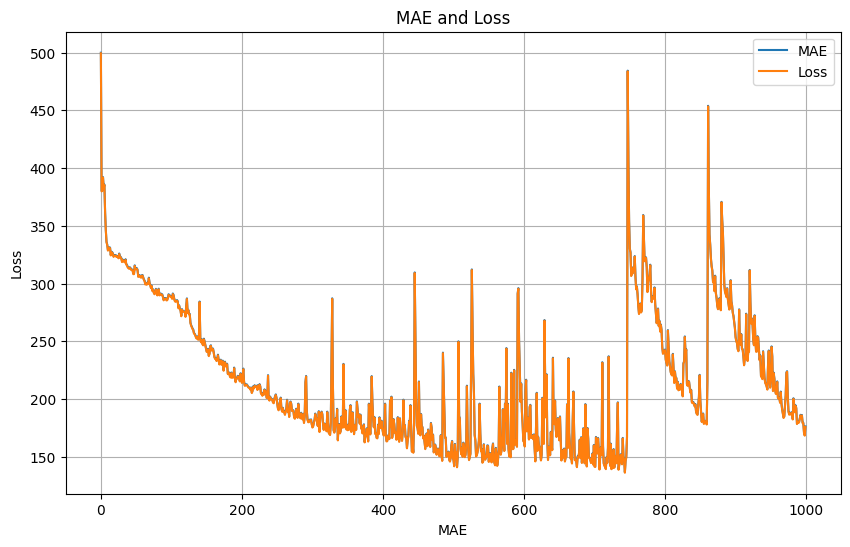

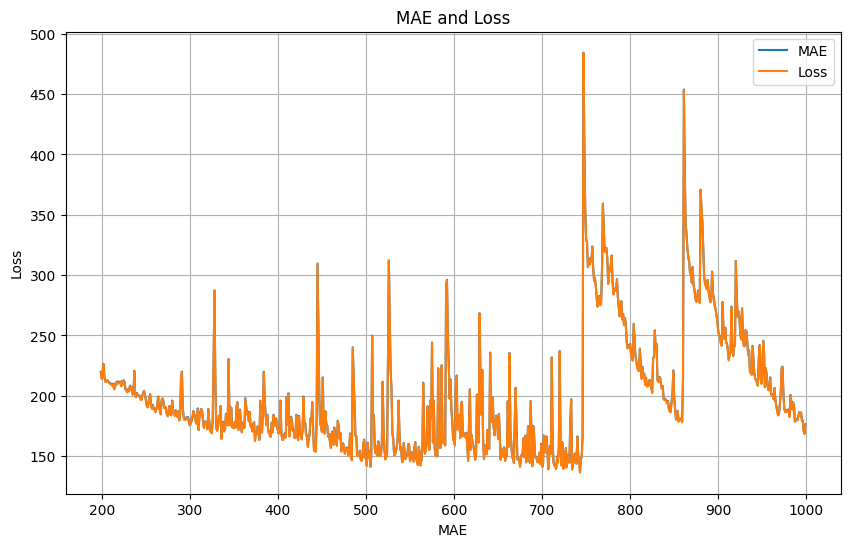

In [17]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [18]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

7/7 [==============================] - 0s 4ms/step


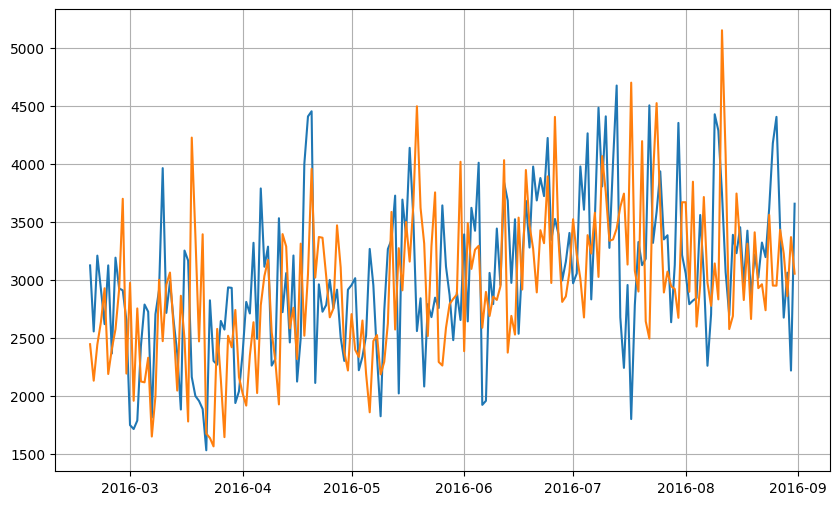

In [19]:
# Show the validation data time series with its prediction

# Reduce the original series
forecast_series = series[SPLIT_TIME-WINDOW_SIZE:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

      1/Unknown - 0s 14ms/step

31/31 [==============================] - 0s 2ms/step
(974,)
(974,)
(967,)


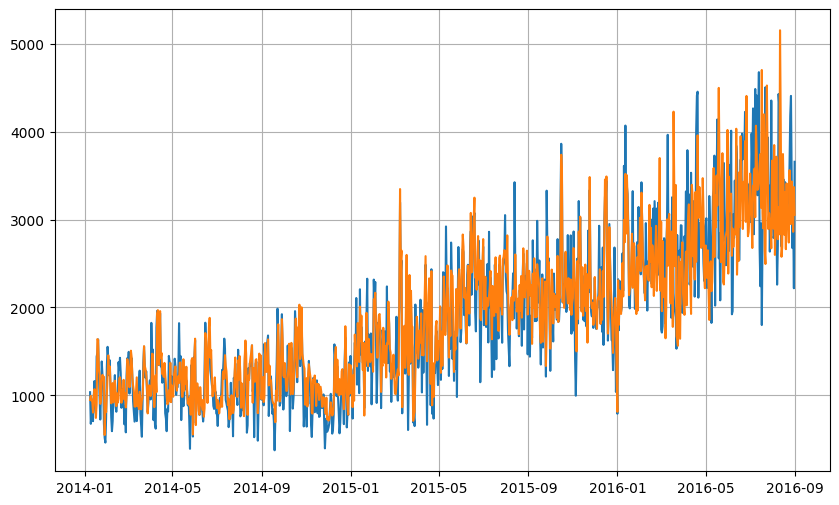

In [20]:
# Show the full time series with its prediction

# Reduce the original series
forecast_series = series[:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

print(time.shape)
print(series.shape)
print(results.shape)

# Plot the results
plot_series(time[WINDOW_SIZE:], (series[WINDOW_SIZE:], results))

31/31 [==============================] - 0s 2ms/step


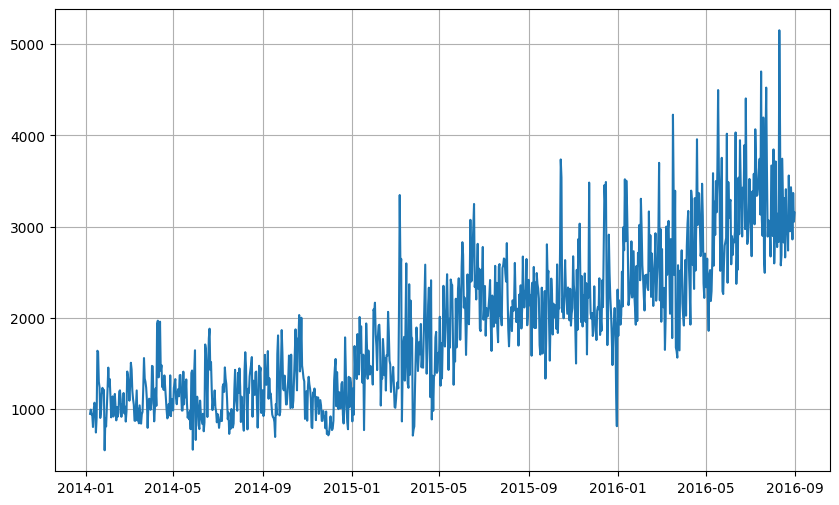

In [26]:
# Define the window size for 30 days
window_size_30_days = 7

# Use helper function to generate predictions for the next 30 days
forecast_30_days = model_forecast(model, series, window_size_30_days, BATCH_SIZE)

# Drop single dimensional axis
results_30_days = forecast_30_days.squeeze()

# Plot the results
plot_series(time[-len(results_30_days):], results_30_days)


2/2 [==============================] - 0s 8ms/step


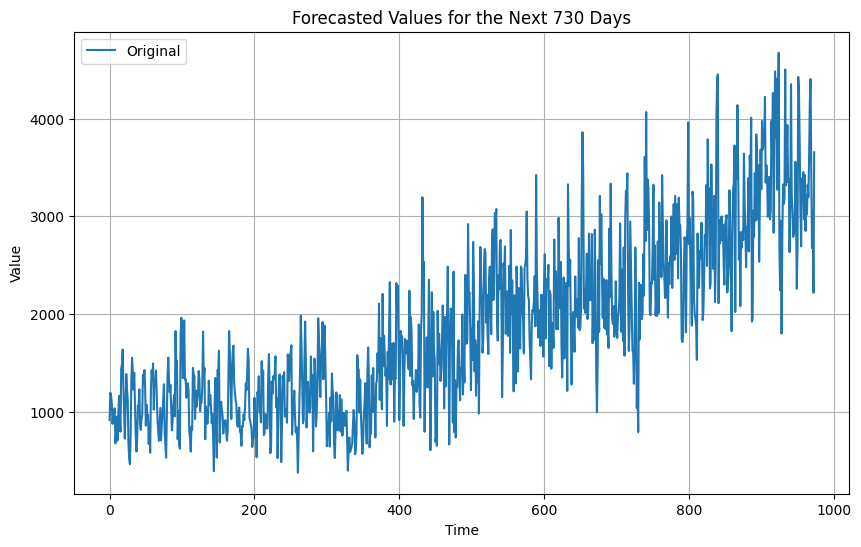

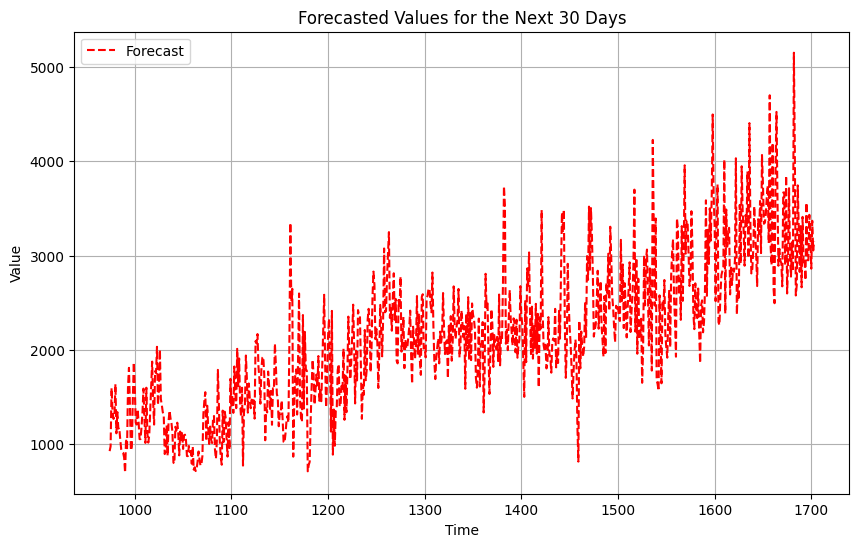

In [49]:
# Number of days to forecast
forecast_days = 730

# Generate forecasted values
forecast_values = model_forecast(model, series, WINDOW_SIZE, forecast_days)

# Plot the original series along with the forecasted values
plot_series(np.arange(len(series)), series, title=f'Forecasted Values for the Next {forecast_days} Days',
            xlabel='Time', ylabel='Value', legend=['Original'])
plot_series(np.arange(len(series), len(series) + forecast_days), forecast_values[-forecast_days:], format='r--',
            title='Forecasted Values for the Next {forecast_days} Days', xlabel='Time', ylabel='Value', legend=['Forecast'])